In [58]:
from google.colab import drive
import os
import pandas as pd

In [35]:
# Mount Google Drive
drive.mount('/content/drive')
# Ścieżka do danych
data_path = '/content/drive/MyDrive/jena'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
data_files = ["mpi_roof_2009a.csv", "mpi_roof_2009b.csv", "mpi_roof_2010a.csv", "mpi_roof_2010b.csv", "mpi_roof_2011a.csv",
         "mpi_roof_2011b.csv","mpi_roof_2012a.csv","mpi_roof_2012b.csv","mpi_roof_2013a.csv","mpi_roof_2013b.csv","mpi_roof_2014a.csv","mpi_roof_2014b.csv",
         "mpi_roof_2015a.csv","mpi_roof_2015b.csv","mpi_roof_2016a.csv","mpi_roof_2016b.csv"]

In [37]:
all_data=[] #lista dla wszystkich dataframe

In [38]:
for file_name in data_files:
    file_path = os.path.join(data_path, file_name)

    # Próba wczytania danych z pliku CSV do DataFrame z różnymi kodowaniami
    for encoding in ['utf-8', 'latin1', 'ISO-8859-1']:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            if df.empty:
                continue  # Jeśli DataFrame jest pusty, kontynuuj próby z innym kodowaniem
            print(f"File: {file_name} (encoding: {encoding})")
            print(f"Headers: {df.columns.tolist()}")
            print(f"Number of lines: {len(df)}\n")
            all_data.append(df)
            break  # Zakończ próbę po pomyślnym wczytaniu
        except UnicodeDecodeError:
            print(f"encoding {encoding}")


encoding utf-8
File: mpi_roof_2009a.csv (encoding: latin1)
Headers: ['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m²)', 'PAR (µmol/m²/s)', 'max. PAR (µmol/m²/s)', 'Tlog (degC)', 'CO2 (ppm)']
Number of lines: 26064

encoding utf-8
File: mpi_roof_2009b.csv (encoding: latin1)
Headers: ['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m²)', 'PAR (µmol/m²/s)', 'max. PAR (µmol/m²/s)', 'Tlog (degC)', 'CO2 (ppm)']
Number of lines: 26494

encoding utf-8
File: mpi_roof_2010a.csv (encoding: latin1)
Headers: ['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPac

In [40]:
# Przetwarzanie danych do tablicy float_data
float_data = np.zeros((len(combined_df), len(combined_df.columns) - 1))
for i in range(len(combined_df)):
    values = combined_df.iloc[i, 1:].values.astype(float)  # Konwersja wartości na float
    float_data[i, :] = values

# Wyświetlenie kształtu float_data
print(f"Shape of float_data: {float_data.shape}")

Shape of float_data: (420551, 21)


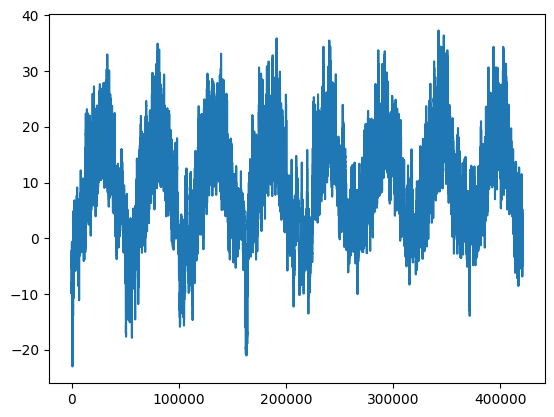

In [41]:
#wykres zmian temp
from matplotlib import pyplot as plt
temp = float_data[:, 1] # Temeperatura (stopnie Celsjusza)
plt.plot(range(len(temp)), temp)
plt.show()


In [42]:
#srednia i odchylenie std
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [48]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
              indices = range(rows[j] - lookback, rows[j], step)
              samples[j] = data[indices]
              targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [51]:
lookback =1440
step =6
delay =144
batch_size =128

In [52]:
train_gen = generator(float_data,
 lookback=lookback,
 delay=delay,
 min_index=0,
 max_index=200000,
 shuffle=True,
 step=step,
 batch_size=batch_size)
val_gen = generator(float_data,
 lookback=lookback,
 delay=delay,
 min_index=200001,
 max_index=300000,
 step=step,
 batch_size=batch_size)
test_gen = generator(float_data,
 lookback=lookback,
 delay=delay,
 min_index=300001,
 max_index=None,
 step=step,
 batch_size=batch_size)


In [53]:
val_steps = (300000 - 200001 - lookback) // batch_size #liczba krokow do przetworzenia calego walid zbioru

In [54]:
test_steps = (len(float_data) - 300001 - lookback) // batch_size #liczba korkow przy ktorej zostanie przetworzony caly zb testowy

In [55]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

In [56]:
# Model LSTM
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

# Kompilacja modelu
model.compile(optimizer=RMSprop(), loss='mae')

In [57]:
# Trenowanie modelu
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 107s 210ms/step - loss: 0.2876 - val_loss: 0.2677
Epoch 2/20
500/500 [==============================] - 107s 214ms/step - loss: 0.2629 - val_loss: 0.2692
Epoch 3/20
500/500 [==============================] - 103s 207ms/step - loss: 0.2516 - val_loss: 0.2719
Epoch 4/20
500/500 [==============================] - 105s 211ms/step - loss: 0.2409 - val_loss: 0.2748
Epoch 5/20
500/500 [==============================] - 104s 207ms/step - loss: 0.2321 - val_loss: 0.2823
Epoch 6/20
500/500 [==============================] - 105s 210ms/step - loss: 0.2234 - val_loss: 0.2849
Epoch 7/20
500/500 [==============================] - 103s 207ms/step - loss: 0.2145 - val_loss: 0.2922
Epoch 8/20
500/500 [==============================] - 105s 211ms/step - loss: 0.2079 - val_loss: 0.2999
Epoch 9/20
500/500 [==============================] - 105s 209ms/step - loss: 0.2020 - val_loss: 0.3039
Epoch 10/20
500/500 [==============================] - 105s 210m

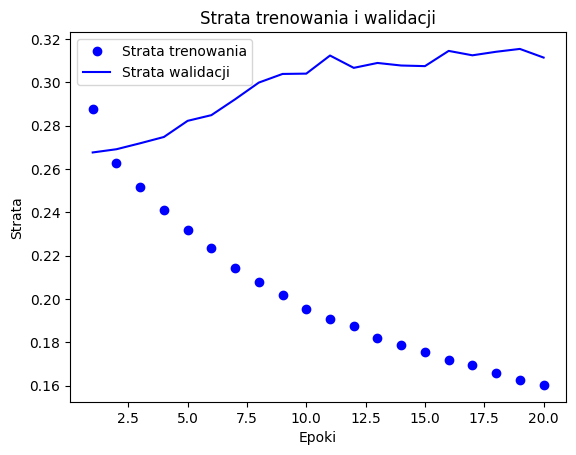

In [59]:
# Wykresy strat
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

In [62]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
#MODEL GRU
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

In [63]:
# Trenowanie modelu
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 117s 218ms/step - loss: 0.2925 - val_loss: 0.2629
Epoch 2/20
500/500 [==============================] - 111s 222ms/step - loss: 0.2723 - val_loss: 0.2630
Epoch 3/20
500/500 [==============================] - 101s 202ms/step - loss: 0.2670 - val_loss: 0.2571
Epoch 4/20
500/500 [==============================] - 103s 207ms/step - loss: 0.2589 - val_loss: 0.2627
Epoch 5/20
500/500 [==============================] - 101s 202ms/step - loss: 0.2534 - val_loss: 0.2618
Epoch 6/20
500/500 [==============================] - 109s 218ms/step - loss: 0.2478 - val_loss: 0.2598
Epoch 7/20
500/500 [==============================] - 101s 202ms/step - loss: 0.2426 - val_loss: 0.2634
Epoch 8/20
500/500 [==============================] - 102s 205ms/step - loss: 0.2386 - val_loss: 0.2649
Epoch 9/20
500/500 [==============================] - 100s 200ms/step - loss: 0.2334 - val_loss: 0.2687
Epoch 10/20
500/500 [==============================] - 109s 218m

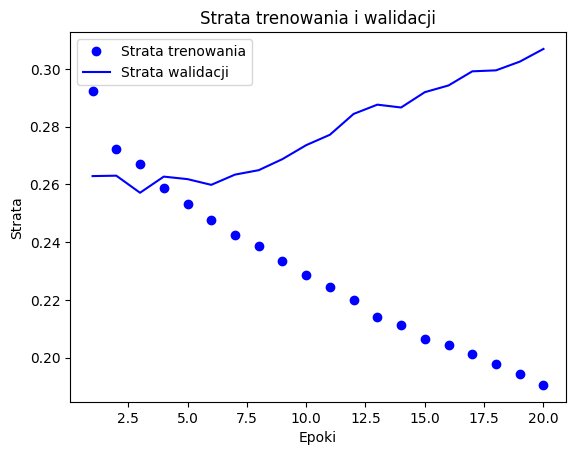

In [64]:
# Wykresy strat
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

In [65]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Bidirectional(
 layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

In [66]:
# Trenowanie modelu
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 176s 345ms/step - loss: 0.2868 - val_loss: 0.2607
Epoch 2/40
500/500 [==============================] - 175s 350ms/step - loss: 0.2680 - val_loss: 0.2609
Epoch 3/40
500/500 [==============================] - 173s 346ms/step - loss: 0.2588 - val_loss: 0.2589
Epoch 4/40
500/500 [==============================] - 200s 400ms/step - loss: 0.2518 - val_loss: 0.2651
Epoch 5/40
500/500 [==============================] - 173s 347ms/step - loss: 0.2463 - val_loss: 0.2643
Epoch 6/40
500/500 [==============================] - 173s 347ms/step - loss: 0.2387 - val_loss: 0.2716
Epoch 7/40
500/500 [==============================] - 175s 349ms/step - loss: 0.2309 - val_loss: 0.2752
Epoch 8/40
500/500 [==============================] - 172s 345ms/step - loss: 0.2258 - val_loss: 0.2821
Epoch 9/40
500/500 [==============================] - 172s 345ms/step - loss: 0.2187 - val_loss: 0.2840
Epoch 10/40
500/500 [==============================] - 173s 346m

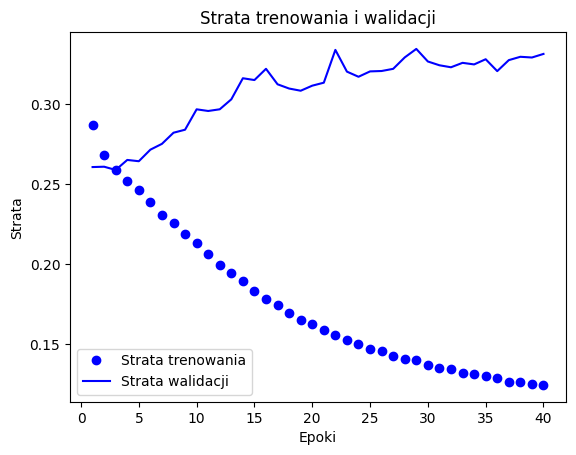

In [67]:
# Wykresy strat
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

In [ ]:
=>Bazując na otrzymanych wykresach modeli: LSTM, GRU oraz Bidirectional można zauważyć, że w 20 epoce wartość straty treningowej osiągała zazwyczaj dość podobne wartości w granicach +-0.15,
strata trenowania natomiast osiąga jak najmniej strome skoki w przypadku modelu GRU, w modelu LSTM dość szybko osiągane są wysokie wartości, co rownież można zauważyć w przypadku Bidirectional.
Wnioski:
-w GRU: strata trenowania szyko maleje, strata walidacyjna natomiast w pierwszych epokach jest niższa niż w późniejszych, bo najprawdopodobniej model
doprowadza do przeuczenia danych treningowych
-w Bidirectional: strtata walidaccyjna jest niższa niż w gru, co może sądzić o lepszym generalizowaniu modelu
-w LSTM: strata trenowania następuje dość łagodnie bez stromych zbocz, zaś strata walidacyjna stale rośnie co może świadczyć również o przecuczeniu, jak wcześniej